=== Top 10 Configurations by DB Index ===
         algo                                                                params        capping  log_transform  n_clusters_formed  db_index  silhouette  calinski_harabasz
       dbscan                 {'algo_name': 'dbscan', 'eps': 1.0, 'min_samples': 5}   (0.01, 0.99)          False                  8  0.683216    0.508084          75.007608
       dbscan                 {'algo_name': 'dbscan', 'eps': 1.0, 'min_samples': 5} (0.005, 0.995)          False                  8  0.684348    0.505188          74.639654
       dbscan                {'algo_name': 'dbscan', 'eps': 1.0, 'min_samples': 10}   (0.01, 0.99)           True                  5  0.734056    0.495094          86.013455
       dbscan                {'algo_name': 'dbscan', 'eps': 1.0, 'min_samples': 10} (0.005, 0.995)           True                  4  0.772223    0.485489          91.440558
       dbscan                 {'algo_name': 'dbscan', 'eps': 1.0, 'min_samples': 5}   (0

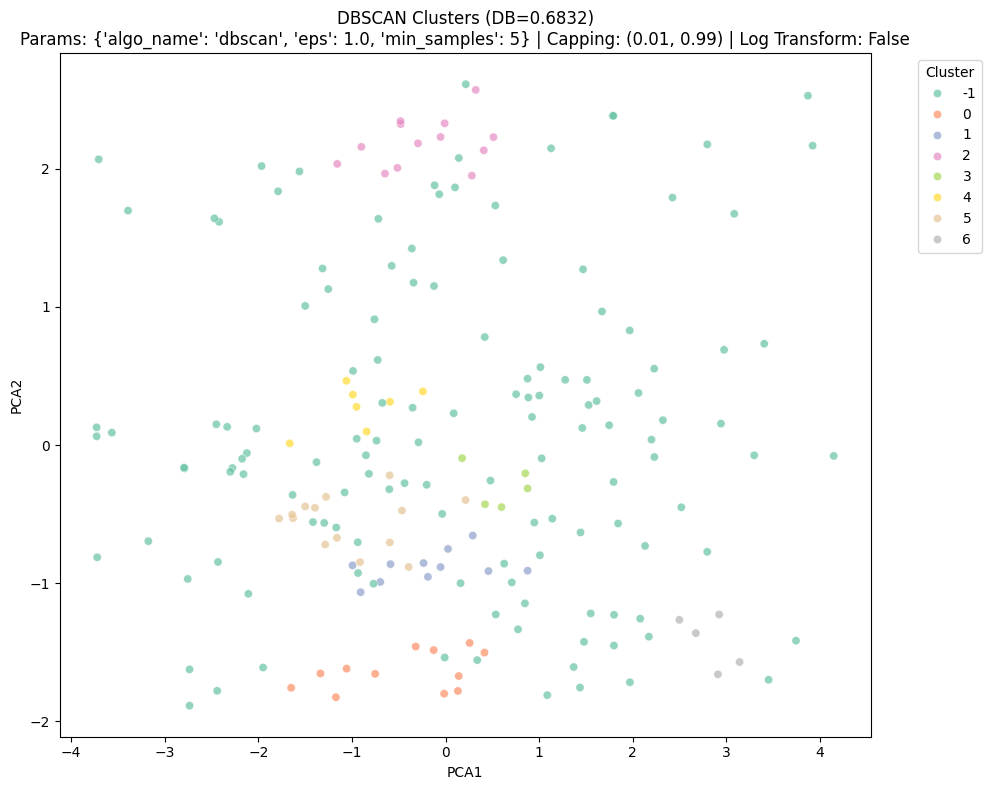

In [3]:
"""
Steps:
    1) Load and merge data (Customers + Transactions)
    2) Feature engineering (total spend, average order, tenure, region dummies)
    3) Outlier capping + optional log(1+x) transform
    4) Try multiple clustering algorithms with different parameters:
        - K-Means
        - Agglomerative Clustering
        - Gaussian Mixture
        - DBSCAN
    5) Record metrics (DB, silhouette, etc.) and pick the best DB.
    6) Output final labels and top configurations.
"""

import pandas as pd
import numpy as np
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (
    davies_bouldin_score,
    silhouette_score,
    calinski_harabasz_score
)
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import sys

# =============================================================
# 0. SETUP LOGGING
# =============================================================
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# =============================================================
# 1. LOAD & MERGE DATA
# =============================================================
logging.info("Loading Customers.csv and Transactions.csv")
try:
    customers = pd.read_csv('Customers.csv')       # CustomerID, CustomerName, Region, SignupDate
    transactions = pd.read_csv('Transactions.csv') # TransactionID, CustomerID, ProductID, ...
except FileNotFoundError as e:
    logging.error(f"File not found: {e}")
    sys.exit(1)

logging.info("Aggregating transaction data per CustomerID")
cust_agg = transactions.groupby('CustomerID').agg({
    'TransactionID': 'count',
    'Quantity': 'sum',
    'TotalValue': 'sum'
}).rename(columns={
    'TransactionID': 'NumTransactions',
    'Quantity': 'TotalQuantity',
    'TotalValue': 'TotalSpend'
}).reset_index()

logging.info("Merging Customers and aggregated Transactions data")
merged_df = pd.merge(customers, cust_agg, on='CustomerID', how='left')

# Fill NaNs for customers with no transactions
merged_df[['NumTransactions','TotalQuantity','TotalSpend']] = \
    merged_df[['NumTransactions','TotalQuantity','TotalSpend']].fillna(0)

# Data validation
assert merged_df['CustomerID'].nunique() == customers['CustomerID'].nunique(), "Merge issue: Mismatch in CustomerIDs."

# =============================================================
# 2. FEATURE ENGINEERING
# =============================================================
logging.info("Converting SignupDate to datetime and calculating CustomerTenure")
merged_df['SignupDate'] = pd.to_datetime(merged_df['SignupDate'], errors='coerce')
max_date = merged_df['SignupDate'].max()
merged_df['CustomerTenure'] = (max_date - merged_df['SignupDate']).dt.days

# Vectorized calculation of AvgOrderValue
logging.info("Calculating AvgOrderValue")
merged_df['AvgOrderValue'] = merged_df['TotalSpend'] / merged_df['NumTransactions'].replace(0, np.nan)
merged_df['AvgOrderValue'] = merged_df['AvgOrderValue'].fillna(0)

# One-hot encode Region
logging.info("One-hot encoding Region")
merged_df = pd.get_dummies(merged_df, columns=['Region'], drop_first=True)

# Features for clustering
feature_cols = ['NumTransactions', 'TotalQuantity', 'TotalSpend',
                'AvgOrderValue', 'CustomerTenure']
region_cols = [c for c in merged_df.columns if c.startswith('Region_')]
df_features = merged_df[feature_cols + region_cols].copy().fillna(0)

# =============================================================
# 3. OUTLIER CAPPING & LOG TRANSFORMATION (Optional)
# =============================================================
def cap_outliers(series, lower_quantile=0.01, upper_quantile=0.99):
    """Clip values between given quantiles."""
    lower_bound = series.quantile(lower_quantile)
    upper_bound = series.quantile(upper_quantile)
    return np.clip(series, lower_bound, upper_bound)

numeric_cols = ['NumTransactions', 'TotalQuantity', 'TotalSpend', 'AvgOrderValue', 'CustomerTenure']

# Different capping thresholds to try:
capping_options = [
    (0.01, 0.99),
    (0.005, 0.995),
]

# Whether to apply log transform:
log_options = [False, True]

# =============================================================
# 4. DEFINE ALGORITHMS & PARAM GRIDS
# =============================================================

logging.info("Defining clustering algorithms and parameter grids")

# 4a. K-Means param grid
kmeans_param_grid = {
    'algo_name': ['kmeans'],
    'n_clusters': [4, 5, 6, 7, 8],
    'n_init': [10, 20],
}

# 4b. Agglomerative param grid
agglo_param_grid = {
    'algo_name': ['agglomerative'],
    'n_clusters': [4, 5, 6, 7, 8],
    'linkage': ['ward', 'complete', 'average']
}

# 4c. Gaussian Mixture param grid
gmm_param_grid = {
    'algo_name': ['gmm'],
    'n_components': [4, 5, 6, 7, 8],  # analogous to n_clusters
    'covariance_type': ['full', 'tied']    # can add 'diag', 'spherical'
}

# 4d. DBSCAN param grid
# Note: We keep a small grid for performance; expand if you want deeper search
dbscan_param_grid = {
    'algo_name': ['dbscan'],
    'eps': [0.5, 1.0, 1.5],
    'min_samples': [5, 10]
}

# Combine all parameter grids into search_spaces list
search_spaces = []
for d in [kmeans_param_grid, agglo_param_grid, gmm_param_grid, dbscan_param_grid]:
    # Turn the dict into a list of dicts
    keys = list(d.keys())
    # e.g., for kmeans_param_grid, keys might be ['algo_name','n_clusters','n_init']
    # We'll create all combos with itertools.product
    param_names = keys[1:]  # everything except 'algo_name'
    param_values = [d[k] for k in param_names]
    for combo in itertools.product(*param_values):
        # Build a dict with algo_name + each param
        cfg = {'algo_name': d['algo_name'][0]}
        for k, val in zip(param_names, combo):
            cfg[k] = val
        search_spaces.append(cfg)

logging.info(f"Total number of clustering configurations to evaluate: {len(search_spaces)}")

# =============================================================
# 5. GRID SEARCH OVER (CAPPING, LOG) x (ALGO PARAMS)
# =============================================================
all_results = []
best_db = float('inf')
best_config = None
best_labels = None
best_scaled_data = None

total_iterations = len(capping_options) * len(log_options) * len(search_spaces)
current_iteration = 1

logging.info(f"Starting grid search over {total_iterations} total configurations.")

for (c_lower, c_upper), do_log in itertools.product(capping_options, log_options):

    logging.info(f"Processing capping: ({c_lower}, {c_upper}), log_transform: {do_log} ({current_iteration}/{total_iterations})")
    current_iteration += 1

    # Prepare a new data copy
    df_tmp = df_features.copy()

    # Outlier capping
    for col in numeric_cols:
        df_tmp[col] = cap_outliers(df_tmp[col], c_lower, c_upper)

    # Optional log transform
    if do_log:
        logging.debug("Applying log1p transformation to numeric features")
        for ccc in ['NumTransactions', 'TotalQuantity', 'TotalSpend', 'AvgOrderValue']:
            # Ensure no negative values before log
            df_tmp[ccc] = np.log1p(df_tmp[ccc].clip(lower=0))
        # Optionally log transform CustomerTenure if desired
        # df_tmp['CustomerTenure'] = np.log1p(df_tmp['CustomerTenure'].clip(lower=0))

    # Scale
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_tmp)

    # For each algo + param set
    for cfg in search_spaces:
        algo_name = cfg['algo_name']
        labels = None

        try:
            if algo_name == 'kmeans':
                k_ = cfg['n_clusters']
                ni_ = cfg['n_init']

                km = KMeans(n_clusters=k_, random_state=42, n_init=ni_)
                labels = km.fit_predict(X_scaled)

            elif algo_name == 'agglomerative':
                k_ = cfg['n_clusters']
                linkage_ = cfg['linkage']

                # Note: 'ward' linkage requires Euclidean distance and is only compatible with 'n_clusters' parameter
                agg = AgglomerativeClustering(n_clusters=k_, linkage=linkage_)
                labels = agg.fit_predict(X_scaled)

            elif algo_name == 'gmm':
                n_comp_ = cfg['n_components']
                cov_type_ = cfg['covariance_type']

                gmm = GaussianMixture(n_components=n_comp_, covariance_type=cov_type_, random_state=42)
                gmm.fit(X_scaled)
                labels = gmm.predict(X_scaled)

            elif algo_name == 'dbscan':
                eps_ = cfg['eps']
                ms_ = cfg['min_samples']

                db = DBSCAN(eps=eps_, min_samples=ms_)
                labels = db.fit_predict(X_scaled)

                # Note: DBSCAN labels noise as -1

            # Compute metrics if we have a valid labels array
            unique_clusters = np.unique(labels)
            if len(unique_clusters) < 2:
                db_index = np.inf  # invalid scenario
                sil_ = -1
                ch_ = -1
            else:
                # For DBSCAN, if too many noise points, consider handling differently
                # Alternatively, filter out noise points before computing metrics
                if algo_name == 'dbscan':
                    # Exclude noise points for metric computation
                    mask = labels != -1
                    if np.sum(mask) < 2:
                        db_index = np.inf
                        sil_ = -1
                        ch_ = -1
                    else:
                        db_index = davies_bouldin_score(X_scaled[mask], labels[mask])
                        sil_ = silhouette_score(X_scaled[mask], labels[mask])
                        ch_ = calinski_harabasz_score(X_scaled[mask], labels[mask])
                else:
                    db_index = davies_bouldin_score(X_scaled, labels)
                    sil_ = silhouette_score(X_scaled, labels)
                    ch_ = calinski_harabasz_score(X_scaled, labels)

            # Store results
            res_dict = {
                'algo': algo_name,
                'params': cfg,
                'capping': (c_lower, c_upper),
                'log_transform': do_log,
                'n_clusters_formed': len(unique_clusters),
                'db_index': db_index,
                'silhouette': sil_,
                'calinski_harabasz': ch_
            }
            all_results.append(res_dict)

            # Check if best so far
            # For DB index, lower is better. Exclude invalid scenarios.
            if db_index < best_db and db_index > 0:
                best_db = db_index
                best_config = {
                    'algo': algo_name,
                    'params': cfg,
                    'capping': (c_lower, c_upper),
                    'log_transform': do_log
                }
                best_labels = labels
                best_scaled_data = X_scaled

        except Exception as e:
            # Catch any errors (e.g., numeric issues)
            logging.warning(f"Error with {algo_name}, config={cfg}, error={e}")
            continue

# Convert results to a DataFrame, sort by DB
results_df = pd.DataFrame(all_results)
results_df.sort_values('db_index', inplace=True, ascending=True)

# Show top 10
print("=== Top 10 Configurations by DB Index ===")
print(results_df.head(10).to_string(index=False))

if best_config:
    print("\n=== Best Overall ===")
    print(f"Algorithm: {best_config['algo']}")
    print(f"Params: {best_config['params']}")
    print(f"Capping: {best_config['capping']}")
    print(f"Log Transform? {best_config['log_transform']}")
    print(f"Best DB Index: {best_db:.4f}")
else:
    print("No valid clustering configuration found (seems unlikely). Exiting.")
    sys.exit()

# =============================================================
# 6. EVALUATE FINAL MODEL
# =============================================================
final_labels = best_labels
unique_labels = np.unique(final_labels)
if len(unique_labels) > 1 and best_scaled_data is not None:
    # Recompute metrics to ensure consistency
    if best_config['algo'] == 'dbscan':
        mask = final_labels != -1
        if np.sum(mask) < 2:
            db_final = np.inf
            sil_final = -1
            ch_final = -1
        else:
            db_final = davies_bouldin_score(best_scaled_data[mask], final_labels[mask])
            sil_final = silhouette_score(best_scaled_data[mask], final_labels[mask])
            ch_final = calinski_harabasz_score(best_scaled_data[mask], final_labels[mask])
    else:
        db_final = davies_bouldin_score(best_scaled_data, final_labels)
        sil_final = silhouette_score(best_scaled_data, final_labels)
        ch_final = calinski_harabasz_score(best_scaled_data, final_labels)

    print(f"\nFinal DB: {db_final:.4f}")
    print(f"Final Silhouette: {sil_final:.4f}")
    print(f"Final Calinski-Harabasz: {ch_final:.2f}")

    # Attach to main DF
    merged_df['Cluster'] = final_labels

    # Optional 2D Visualization
    logging.info("Performing PCA for visualization")
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(best_scaled_data)
    merged_df['PCA1'] = X_pca[:,0]
    merged_df['PCA2'] = X_pca[:,1]

    plt.figure(figsize=(10,8))
    sns.scatterplot(data=merged_df, x='PCA1', y='PCA2', hue='Cluster', palette='Set2', legend='full', alpha=0.7)
    plt.title(
        f"{best_config['algo'].upper()} Clusters (DB={db_final:.4f})\n"
        f"Params: {best_config['params']} | Capping: {best_config['capping']} | Log Transform: {best_config['log_transform']}"
    )
    plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # Save final
    output_filename = 'MultiAlgo_BestClusteredCustomers.csv'
    merged_df.to_csv(output_filename, index=False)
    logging.info(f"Final clustered data saved to {output_filename}")

else:
    print("Best model produced 0 or 1 cluster; no meaningful DB index.")
